In [9]:
%matplotlib inline

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from typing import Iterable, List
from timeit import default_timer as timer

import torch
import torch.nn as nn
from torch.nn import Transformer
from torch import Tensor

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from meteostat import Point, Daily, Hourly, Stations
import datetime
from sklearn.preprocessing import StandardScaler

np.random.seed(0)
torch.manual_seed(0)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Want to remove NaN entries and build a temperature model from sufficient data

lat = 47.6
lon = -122.3
data=Daily(Point(lat,lon)).fetch()
data.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
1943-10-02,16.0,12.4,25.2,NaN,NaN,169.0,11.0,NaN,1015.2,NaN
1943-10-03,16.3,12.4,21.3,NaN,NaN,145.0,8.6,NaN,1017.6,NaN
1943-10-04,15.0,10.7,21.3,NaN,NaN,169.0,9.7,NaN,1015.5,NaN
1943-10-05,16.6,14.6,19.6,NaN,NaN,208.0,10.0,NaN,1022.9,NaN
1943-10-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='time'>

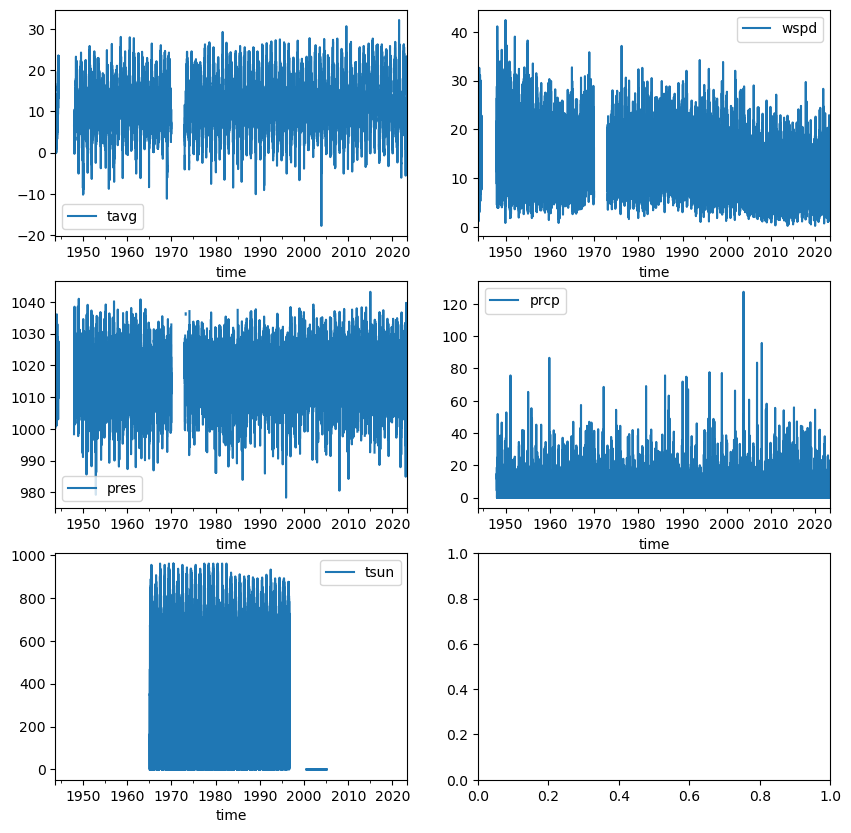

In [6]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

data['tavg'].plot(ax=ax[0][0], legend=True)
data['wspd'].plot(ax=ax[0][1], legend=True)
data['pres'].plot(ax=ax[1][0], legend=True)
data['prcp'].plot(ax=ax[1][1], legend=True)
data['tsun'].plot(ax=ax[2][0], legend=True)

# As you can see, there is a gap in the data ~ 1970. However, we can get sufficient data by stating ~ 1975

In [7]:
# Define start and end times
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2023, 1, 1)

data = Hourly(Point(lat,lon), start=start, end=end).fetch()

# Find how much data we have
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26305 entries, 2020-01-01 00:00:00 to 2023-01-01 00:00:00
Freq: H
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    26305 non-null  float64
 1   dwpt    26305 non-null  float64
 2   rhum    26305 non-null  float64
 3   prcp    26231 non-null  float64
 4   snow    0 non-null      float64
 5   wdir    26305 non-null  float64
 6   wspd    26305 non-null  float64
 7   wpgt    0 non-null      float64
 8   pres    26305 non-null  float64
 9   tsun    0 non-null      float64
 10  coco    26073 non-null  float64
dtypes: float64(11)
memory usage: 2.4 MB


In [8]:
# Extract all relevant channels and impute and missing values
data_cleaned = data[['temp', 'dwpt', 'prcp', 'wspd', 'wdir','pres']]
print(data_cleaned.isna().any())

# Use linear interpolation to fill in NA values
data_cleaned['temp'].interpolate(method='linear', inplace=True)
data_cleaned['dwpt'].interpolate(method='linear', inplace=True)
data_cleaned['prcp'].interpolate(method='linear', inplace=True)
data_cleaned['wspd'].interpolate(method='linear', inplace=True)
data_cleaned['wdir'].interpolate(method='linear', inplace=True)
data_cleaned['pres'].interpolate(method='linear', inplace=True)
print(data_cleaned.isna().any())

temp    False
dwpt    False
prcp     True
wspd    False
wdir    False
pres    False
dtype: bool
temp    False
dwpt    False
prcp    False
wspd    False
wdir    False
pres    False
dtype: bool


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [11]:
# Model takes 5 days and then predicts 3 

testing_sequence_len = 8 * 24

# Convert to numpy array 
y = data_cleaned.values

scaler = StandardScaler()

scaler.fit(y)

y_scaled = scaler.transform(y)

y_train = y_scaled[:-testing_sequence_len]

In [ ]:
class PositionalEncoding(nn.Module): # <-- "Embedding"
    def __init__(self, emb_size, dropout, maxlen = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers,
                 num_decoder_layers,
                 embedding_size,
                 num_heads,
                 src_vocab_size,
                 tgt_vocab_size,
                 dim_feedforward = 512,
                 dropout = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=embedding_size,
                                       nhead=num_heads,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(embedding_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, embedding_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, embedding_size)
        self.positional_encoding = PositionalEncoding(
            embedding_size, dropout=dropout)

    def forward(self,
                src,
                trg,
                src_mask,
                tgt_mask,
                src_padding_mask,
                tgt_padding_mask,
                memory_key_padding_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src)) # source sequence --> token embedding --> positional encoding
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg)) # target sequence --> token embedding --> positional encoding
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, 
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [ ]:
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE]) 
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NUM_HEADS = 8 # Why 8? What do you expect to happen if we increase this parameter?
FFN_HID_DIM = 512 
BATCH_SIZE = 1
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
NUM_EPOCHS = 6

In [ ]:
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NUM_HEADS, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
# Fair warning: you might get an "out of memory" error
# If that happens, try reducing the batch size

train_loss_list = []
val_loss_list = []
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    train_loss_list.extend(train_loss)
    end_time = timer()
    val_loss = evaluate(transformer)
    val_loss_list.extend(val_loss)
    print((f"Epoch: {epoch}, Epoch time = {(end_time - start_time):.3f}s"))
